In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.stats import powerlaw, halfgennorm
import numpy as np
from math import log

In [4]:
"""
This is the state of the data from where we left off in 'distribution_analysis'

The analysis showed that clipping the distribution between 1 and 30 clicks allowed the best fit using the
powerlaw distribution.
"""
original_df = pd.read_csv('data/original/fm_interactions.csv', delimiter='\t')
interaction_df = original_df[original_df['interaction_type'].isin([1, 2, 3])]
user_group = interaction_df.groupby(['user_id'])
user_interaction_count = user_group['item_id'].count()
clipped_interactions = user_interaction_count.clip(1, 31)

In [5]:
"""
These are the fitted params for the fitted halfgennorm distribution
"""
fitted_params = (0.325, .9, .2, )

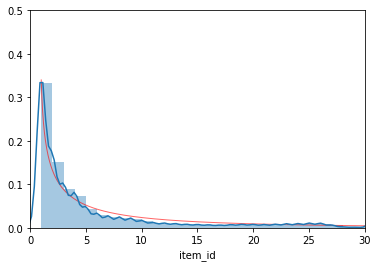

0.340248827042


In [6]:
"""
For starters we'll plot the halfgennorm probability distribution function in its original form...
"""
x = np.linspace(1, 30, 1000)
plt.plot(x, halfgennorm.pdf(x, *fitted_params),
       'r-', lw=1, alpha=0.6, label='powerlow pdf')
sns.distplot(clipped_interactions, bins=30)
plt.xlim(0, 30)
plt.ylim(0, .5)
plt.show()
print(halfgennorm.pdf(1, *fitted_params))

In [7]:
powerlaw_params = (0.45, 0.9, 30)

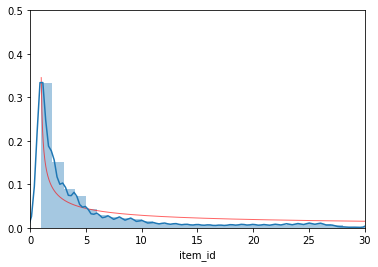

0.345547654285


In [8]:
x = np.linspace(1, 30, 1000)
plt.plot(x, powerlaw.pdf(x, *powerlaw_params),
       'r-', lw=1, alpha=0.6, label='powerlow pdf')
sns.distplot(clipped_interactions, bins=30)
plt.xlim(0, 30)
plt.ylim(0, .5)
plt.show()
print(powerlaw.pdf(1, *powerlaw_params))

In [9]:
dist = halfgennorm
initial_a_to_b_ratio = .55

buckets = 31

x = np.linspace(1, buckets, buckets)

C = halfgennorm.pdf(x, *fitted_params)

B = np.multiply((buckets - x) * initial_a_to_b_ratio / buckets, C)

A = C - B

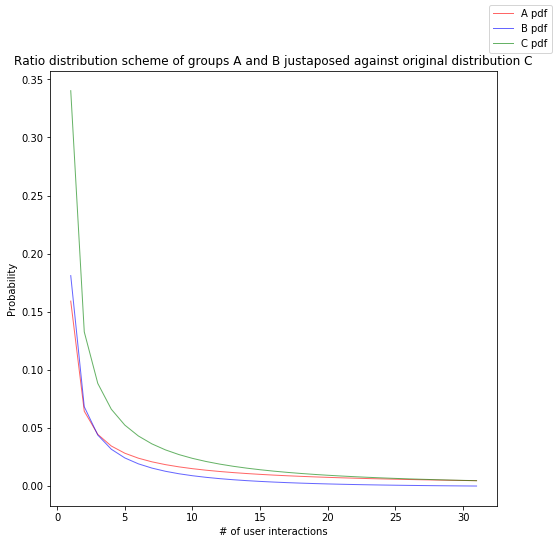

In [10]:
fig = plt.figure(figsize=(8, 8))
x = np.linspace(1, buckets, buckets)
plt.plot(x, A, 'r-', lw=1, alpha=0.6, label='A pdf')
plt.plot(x, B, 'b-', lw=1, alpha=0.6, label='B pdf')
plt.plot(x, C, 'g-', lw=1, alpha=0.6, label='C pdf')
plt.title('Ratio distribution scheme of groups A and B justaposed against original distribution C')
plt.xlabel('# of user interactions')
plt.ylabel('Probability')
fig.legend()
plt.show()

In [14]:
user_df = clipped_interactions.to_frame()
user_df.columns = ['interaction_count']
user_df['user_id'] = user_df.index
interaction_count_df = user_df.groupby(['interaction_count']).count()
interaction_count_df.columns = ['num_users']
interaction_count_df['interaction_count'] = interaction_count_df.index

In [19]:
real_prob_a_dict = {}
synthetic_prob_a_dict = {}
buckets = 31

x = np.linspace(1, buckets, buckets)

for ratio in np.arange(.5, 1, .02):
    C = halfgennorm.pdf(x, *fitted_params)
    B = np.multiply((buckets - x) * ratio / buckets, C)
    A = C - B
    prob_A = A / (A + B)
    
    synthetic_prob_a_dict[ratio] = sum(A) / (sum(A) + sum(B))

    lambda_mapping = {'interaction_count': range(1, 32), 'prob_a': [prob_A[idx] for idx in range(31)]}

    prob_A_df = pd.DataFrame.from_dict(lambda_mapping)
    
    # we assign the item to group A if the probability is greater than 0.5 for now. We will assign A randomly
    # later, when we have decided the ideal lambda
    prob_count_df = prob_A_df.merge(interaction_count_df, on=['interaction_count'])
    prob_count_df['expectation_a'] = prob_count_df['prob_a'] * prob_count_df['num_users']
    sum_df = prob_count_df.sum()
    a_prob = sum_df['expectation_a'] / sum_df['num_users']
    real_prob_a_dict[ratio] = a_prob

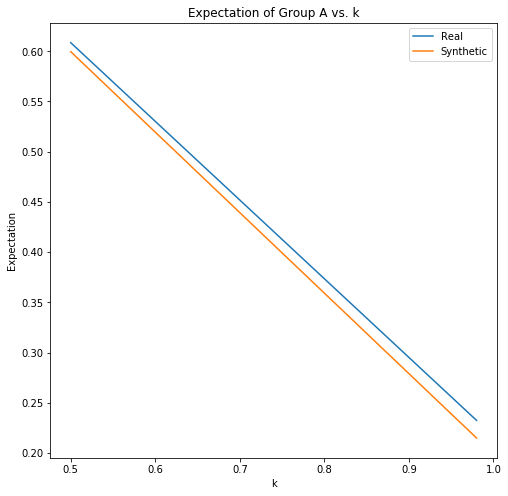

In [22]:
fig = plt.figure(figsize=(8, 8))
plt.plot(real_prob_a_dict.keys(), real_prob_a_dict.values(), label='Real')
plt.plot(synthetic_prob_a_dict.keys(), synthetic_prob_a_dict.values(), label='Synthetic')
plt.title('Expectation of Group A vs. k')
plt.xlabel('k')
plt.ylabel('Expectation')
plt.legend()
plt.plot()
plt.show()

In [23]:
real_prob_a_dict

{0.5: 0.60849447016942004,
 0.52000000000000002: 0.59283424897619708,
 0.54000000000000004: 0.57717402778297378,
 0.56000000000000005: 0.56151380658975059,
 0.58000000000000007: 0.54585358539652762,
 0.60000000000000009: 0.53019336420330432,
 0.62000000000000011: 0.51453314301008102,
 0.64000000000000012: 0.49887292181685777,
 0.66000000000000014: 0.48321270062363464,
 0.68000000000000016: 0.46755247943041128,
 0.70000000000000018: 0.4518922582371882,
 0.7200000000000002: 0.43623203704396507,
 0.74000000000000021: 0.42057181585074188,
 0.76000000000000023: 0.40491159465751875,
 0.78000000000000025: 0.38925137346429556,
 0.80000000000000027: 0.37359115227107231,
 0.82000000000000028: 0.35793093107784918,
 0.8400000000000003: 0.34227070988462593,
 0.86000000000000032: 0.32661048869140263,
 0.88000000000000034: 0.31095026749817961,
 0.90000000000000036: 0.29529004630495626,
 0.92000000000000037: 0.27962982511173312,
 0.94000000000000039: 0.26396960391850999,
 0.96000000000000041: 0.248309

In [24]:
synthetic_prob_a_dict

{0.5: 0.59953975121245384,
 0.52000000000000002: 0.58352134126095179,
 0.54000000000000004: 0.56750293130944995,
 0.56000000000000005: 0.55148452135794812,
 0.58000000000000007: 0.53546611140644618,
 0.60000000000000009: 0.51944770145494434,
 0.62000000000000011: 0.50342929150344251,
 0.64000000000000012: 0.48741088155194062,
 0.66000000000000014: 0.47139247160043873,
 0.68000000000000016: 0.45537406164893685,
 0.70000000000000018: 0.43935565169743512,
 0.7200000000000002: 0.42333724174593307,
 0.74000000000000021: 0.40731883179443135,
 0.76000000000000023: 0.39130042184292946,
 0.78000000000000025: 0.37528201189142762,
 0.80000000000000027: 0.35926360193992557,
 0.82000000000000028: 0.34324519198842379,
 0.8400000000000003: 0.32722678203692196,
 0.86000000000000032: 0.31120837208542002,
 0.88000000000000034: 0.29518996213391824,
 0.90000000000000036: 0.27917155218241629,
 0.92000000000000037: 0.26315314223091457,
 0.94000000000000039: 0.24713473227941271,
 0.96000000000000041: 0.23111